In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
from scipy.signal import convolve
import time
from sklearn.linear_model import LinearRegression
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

/home/charl/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-rc1
 Built: Feb 21 2024 09:04:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:

seed = 1
num_threads = 1
dt = 0.1


In [3]:
# generate and build code
module_name, neuron_model_name = \
   NESTCodeGeneratorUtils.generate_code_for("inhomogeneous_poisson.nestml")
#    NESTCodeGeneratorUtils.generate_code_for("doc/tutorials/inhomogeneous_poisson/inhomogeneous_poisson.nestml")
#   "nestml_afb0fe489e2f4893971cdfaf2781886c_module", "inhomogeneous_poissonafb0fe489e2f4893971cdfaf2781886c_nestml"
# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-rc1
 Built: Feb 21 2024 09:04:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
[12,inhomogeneous_poissonf5b9fa1b15eb40118dc834e32b5b257e_nestml, WARNING, [1:0;26:0]]: Input block not defined!
[13,inhomogeneous_poissonf5b9fa1b15eb40118dc834e32b5b257e_nestml, WARNING, [9:8;9:20]]: Variable 'N' has the same name as a physical unit!
[17,inhomogeneous_poissonf5b9fa1b15eb40118dc834e32b5b257e_nestml, WARNING, [1:0;26:0]]: Input block not defined!
[18,inhomogeneous_poissonf5b9fa1b15eb40118dc834e32b5b257e_nestml, WARNING, [9:8;9:20]]: Variable 'N' has the same name as a physical unit!
CMake Warning (dev) at CMake

In [4]:
def stimulus_representation(neuron_model, input_times, input_amplitudes, sig, seed=1):
    sim_time = num_steps*step_duration
    
    n_neurons = 100

    np.random.seed(seed)
    nest.ResetKernel()
    nest.SetKernelStatus({'rng_seed': seed, 'resolution': dt, 'print_time': True, 'local_num_threads': num_threads})    

    # create inhomogeneous poisson generator (time-dependent input signal)
    stim_pgen = nest.Create(neuron_model, n_neurons)
    stim_pgen_params = {'rate_times': input_times, 'rate_values': input_amplitudes}
    if "N" in stim_pgen.get().keys():
        stim_pgen_params['N'] = len(input_times)
    nest.SetStatus(stim_pgen, params=stim_pgen_params)

    sr = nest.Create('spike_recorder')
    nest.Connect(stim_pgen, sr)
    
    nest.Simulate(sim_time)
    
    activity = nest.GetStatus(sr, 'events')[0]

    rate_estimated, rate_estimated_bin_edges = np.histogram(activity['times'], bins=100)
    rate_estimated_bin_centers = (rate_estimated_bin_edges[:-1] + rate_estimated_bin_edges[1:]) / 2
    bin_width = np.diff(rate_estimated_bin_centers)[0]
    rate = rate_estimated / bin_width
    rate /= n_neurons
    rate *= 1E3

    # Plot
    fig = plt.figure(figsize=(20, 5))
    ax11 = fig.add_subplot(211)
    ax12 = fig.add_subplot(212, sharex=ax11)
    ax11.plot(activity['times'], activity['senders'], '.k', markersize=1)
    ax11.set_xlim([0., sim_time])
    ax12.plot(times, sig, 'r', linewidth=2)

    ax12.plot(rate_estimated_bin_centers, rate, linewidth=2, c='green')
    ax12.set_xlabel(r'Time [ms]')
    fig.savefig("/tmp/ip"+neuron_model+".png")
    plt.show()

    return activity['times'], activity['senders']


In [5]:


def generate_input(num_steps, step_duration, resolution, distr_max, distr_min=0.):
    """
    Generates a piecewise constant input signal with amplitudes drawn from a uniform distribution

    Parameters
    ----------
    num_steps: int
        number of steps in the step function
    step_duration: int
        duration of each step in ms
    resolution: float
        resolution of the generated signal
    scale: float
        amplitude scaling parameter
    Returns
    -------
    ndarray
        continuous input signal (between -1 and 1)
    ndarray
        time vector with all the times for which the signal is generated
    ndarray
        times at which signal amplitude shifts
    ndarray
        amplitudes
    """
    dist_range = [distr_min, distr_max]
    rand_distr = np.random.uniform(low=dist_range[0], high=dist_range[1], size=num_steps)
    rand_distr = rand_distr + abs(min(dist_range))
    inp_times = np.arange(resolution, num_steps * step_duration, step_duration)
    time_vec = np.arange(0, num_steps * step_duration + resolution, resolution)
    signal = np.zeros_like(time_vec)
    for tt in range(len(inp_times)):
        end_idx = int(round(inp_times[tt + 1] / resolution)) if tt + 1 < len(inp_times) else None
        signal[int(round(inp_times[tt] / resolution)):end_idx] = rand_distr[tt]

    return signal, time_vec, inp_times, rand_distr



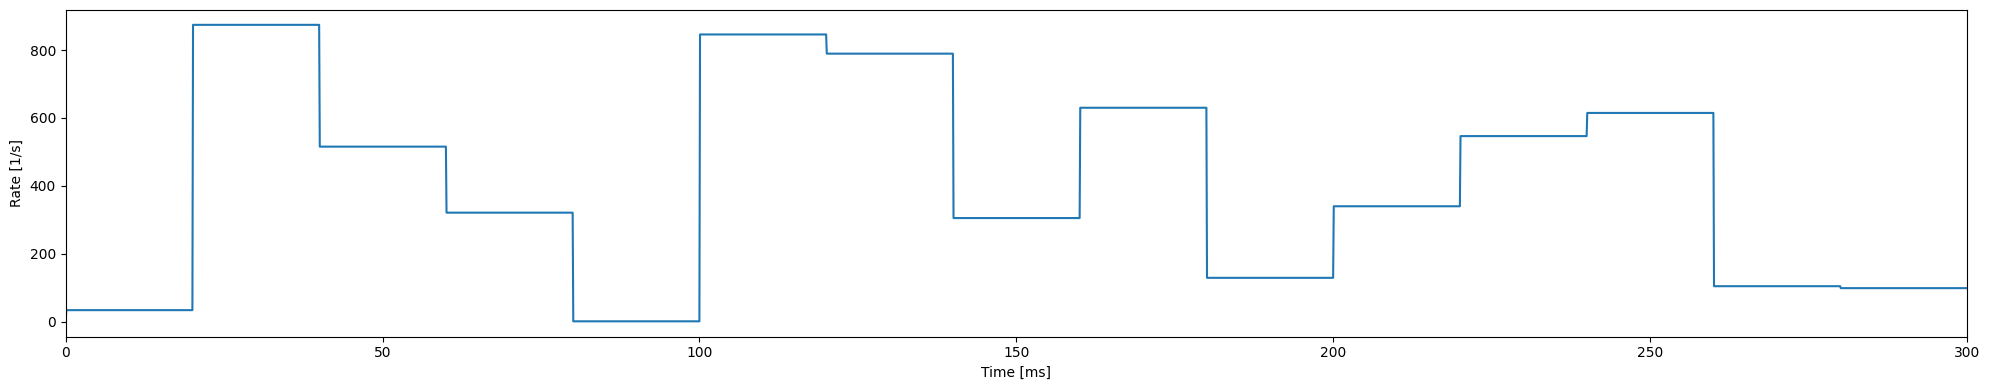

In [6]:
step_duration = 20.   # duration of each step [ms]
num_steps = 15       # number of unique input values

rate, times, inp_times, inp_amplitudes = generate_input(num_steps=num_steps,
                                                        step_duration=step_duration,
                                                        resolution=dt,
                                                        distr_max=1000.)

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(times, rate)
ax.set_xlim([0, num_steps * step_duration])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Rate [1/s]')
fig.tight_layout()


Feb 23 11:19:16 inhomogeneous_poissonf5b9fa1b15eb40118dc834e32b5b257e_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 23 11:19:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 23 11:19:16 NodeManager::prepare_nodes [Info]: 
    Preparing 101 nodes for simulation.

Feb 23 11:19:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 101
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

[ 100% ] Model time: 300.0 ms, Real-time factor: 0.0902

Feb 23 11:19:16 SimulationManager::run [Info]: 
    Simulation finished.


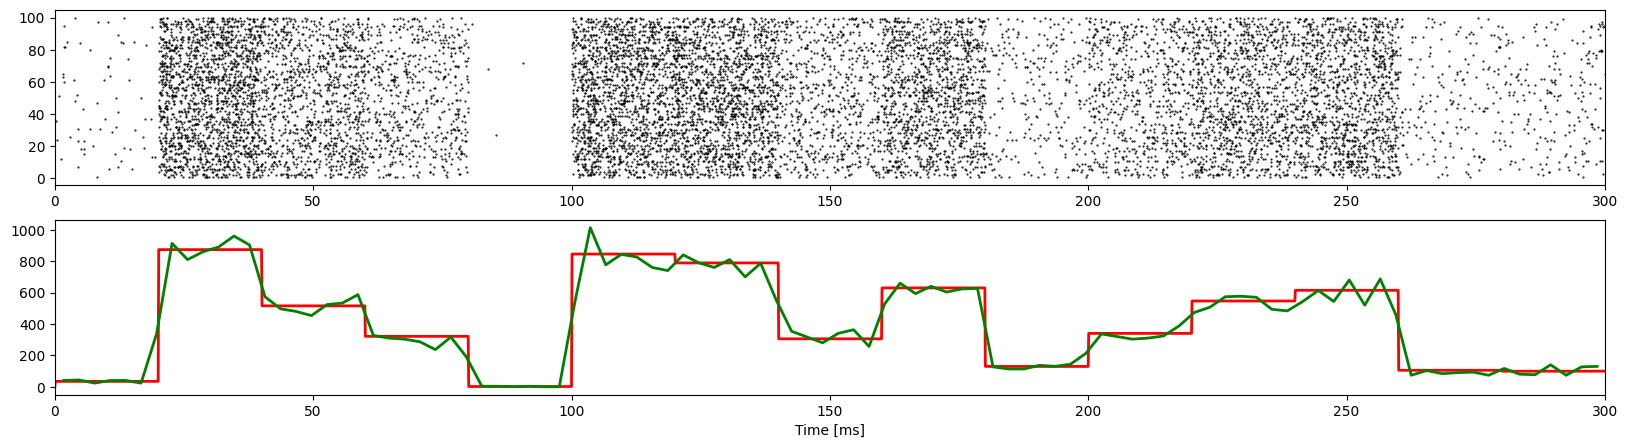

(array([5.000e-01, 2.000e-01, 9.000e-01, ..., 2.998e+02, 2.995e+02,
        2.995e+02]),
 array([24, 36, 51, ..., 95, 96, 97]))

In [7]:
stimulus_representation('inhomogeneous_poisson_generator', inp_times, inp_amplitudes, rate)


Feb 23 11:19:17 inhomogeneous_poissonf5b9fa1b15eb40118dc834e32b5b257e_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 23 11:19:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 23 11:19:17 NodeManager::prepare_nodes [Info]: 
    Preparing 101 nodes for simulation.

Feb 23 11:19:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 101
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

[ 100% ] Model time: 300.0 ms, Real-time factor: 0.0332

Feb 23 11:19:17 SimulationManager::run [Info]: 
    Simulation finished.


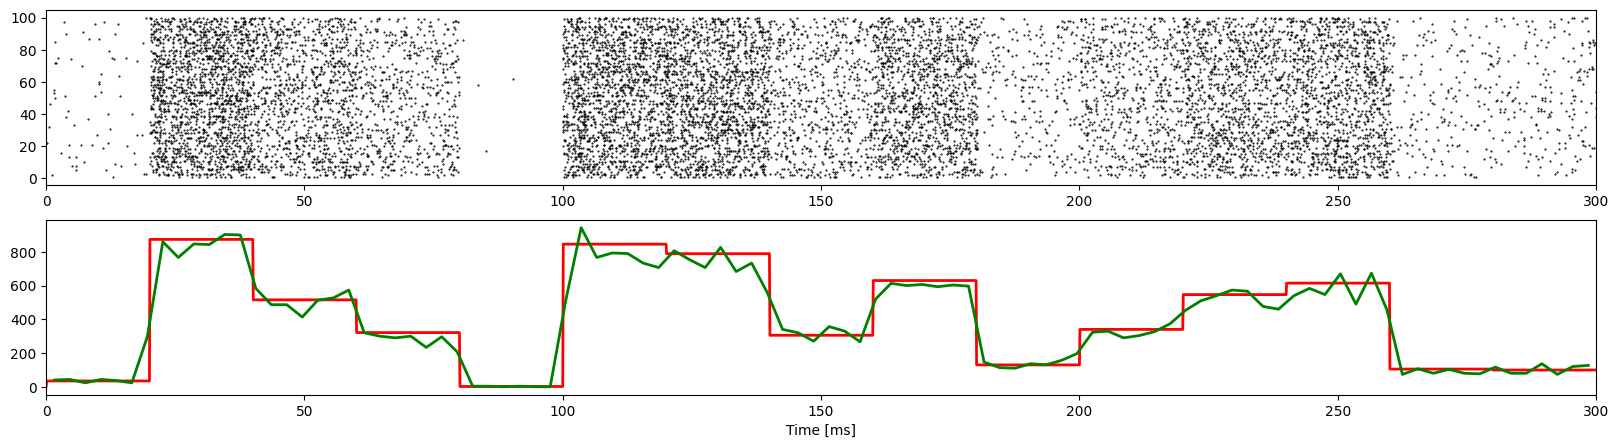

(array([1.000e-01, 6.000e-01, 8.000e-01, ..., 2.997e+02, 2.994e+02,
        2.994e+02]),
 array([22, 32, 46, ..., 84, 85, 86]))

In [8]:
stimulus_representation(neuron_model_name, inp_times, inp_amplitudes, rate)
